# Постановка задачи

Классификация отзывов о банке по категориям (ипотека, дебетовые карты, обслуживание юр лиц и т.д.)

Области применения результатов работы будут обозначены в заключительной части


Датасет собирался с сайта Banki ru самостоятельно, ноутбук со скрапингом доступен по [ссылке](https://colab.research.google.com/drive/15O5DF4R8ZTIE8m7XwCr0RyTdP4wgQqcT?usp=sharing) 


Обращаю внимание, что данную функцию можно переиспользовать, выбирать любой банк, любые категории, ограничивать количество загружаемых страниц с отзывами. Для примера был выбран банк Тинькофф

# Предварительная обработка

In [ ]:
import numpy as np
import pandas as pd
import re
import gc
import os
import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Так как на сбор датасет требуется более 10 минут, я выгрузил его на свой dropbox для экономии времени

In [ ]:
df = pd.read_csv('https://dl.dropbox.com/s/fe3mpksl9eij9kn/alldf.csv', sep='\t')
df

,Unnamed: 0,time,product,title,full_text,mark
0,0,15.06.2021 9:28,debitcards,\nГорячая линия (не мог войти в приложение)\n,Сегодня впервые воспользовался горячей линией ...,Оценка:\n\n\t\t\t5\n\t\t\n\n\t\t\t\t\t\t\tПров...
1,1,15.06.2021 9:23,debitcards,\nСАМЫЙ НЕБЕЗОПАСНЫЙ БАНК!!\n,Тинькофф заморозили счета до 5 июля .Служба бе...,Оценка:\n\n\t\t\t1\n\t\t\n\n\t\t\t\t\t\t\tПров...
2,2,15.06.2021 8:58,debitcards,\nБыл вход с другого устройства. Списали деньг...,Пользовался другим банком до этого таких пробл...,Оценка:\n\n\t\t\t1\n\t\t\n\n\t\t\t\t\t\t\tПров...
3,3,15.06.2021 8:57,debitcards,\nБанк дорожит своими клиентами\n,"Я пенсионер, возраст 60+. Пользуюсь только бе...",Оценка:\n\n\t\t\t5\n\t\t\n\n\t\t\t\t\t\t\tПров...
4,4,15.06.2021 8:50,debitcards,"\nПрекрасный банк, который не стыдно посоветов...","Знакомство с банком у меня началось с того, чт...",Оценка:\n\n\t\t\t5\n\t\t\n\n\t\t\t\t\t\t\tПров...
...,...,...,...,...,...,...
9759,2042,26.05.2015 23:53,corporate,\nНеуважительное отношение\n,"Много слышал историй про Банк Тинькофф, хороши...",Без оценки
9760,2043,20.05.2015 19:24,corporate,\nТы мог был быть хорошим другом...\n,Предисловие.Были чудные времена когда банком и...,Оценка:\n\n\t\t\t3\n\t\t\n\n\nПроблема решена
9761,2044,19.05.2015 13:21,corporate,\nРекламный спам\n,Банк занимается рекламным спамом. Звонят и пре...,Без оценки
9762,2045,20.08.2014 16:54,corporate,"\nМучения с банком ТКС, ужасная оперативность....","Мне лично нравится Тиньков, я смотрел передачи...",Без оценки


In [ ]:
def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace("\s{2,}", " ")
    return text

In [ ]:
df["full_text"]=normalise_text(df["full_text"])

In [ ]:
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

**Примечание**: для задачи классификации отзывов по категориям обработанные ниже данные по оценкам не пригодились. Однако это может потребоваться в будущем, при улучшении моделей

Новый cуррогатный признак - столбец **checked** засчитана ли оценка после проверки модераторами:
*   -1 (оценка Не засчитана)
*   0 (оценка Не проверена или отсутствует)
*   1 (оценка Проверена и засчитана)
*   2 (проблема решена)

In [ ]:
def f_checked(row):
  if 'Не засчитана' in row['mark']:
    val = -1
  elif ('Проверяется' in row['mark']) or ('Без оценки' in row['mark']):
    val = 0
  elif 'Проблема решена' in row['mark']:
    val = 2
  else:
    val = 1
  return val

df['checked'] = df.apply(f_checked, axis=1)

Также выделим оценку из столбца mark

In [ ]:
def mark_clean(row):
  if 'Без оценки' in row['mark']:
    val = -1
  elif '1' in row['mark']:
    val = 1
  elif '2' in row['mark']:
    val = 2
  elif '3' in row['mark']:
    val = 3
  elif '4' in row['mark']:
    val = 4
  elif '5' in row['mark']:
    val = 5
  return val

df['mark'] = df.apply(mark_clean, axis=1)

In [ ]:
df.drop(['Unnamed: 0', 'time', 'title'], axis=1, inplace=True)
df.columns = ['Label', 'Text', 'Mark', 'Checked']
df

,Label,Text,Mark,Checked
0,remote,добрый день! много раз пополнял до этого карту...,1,1
1,corporate,хотел бы оставить отзыв о самом удобном банке....,5,-1
2,corporate,прошу обратить внимание на нашу проблему.у нас...,2,-1
3,business_remote,"пользуюсь банком как ип, получаю платежи от ин...",2,1
4,remote,являюсь клиентом тинькофф банка с ноября 2019 ...,5,1
...,...,...,...,...
9759,hypothec,"добрый день. меня зовут лидия, я риэлтор в дан...",5,-1
9760,corporate,открыли расчётный счет в этом банке для торгов...,-1,0
9761,debitcards,хочу оставить отзыв о работе с клиентами в тин...,4,1
9762,remote,"здравствуйте! если вы госслужащий, или хотите ...",1,2


# Описательный Анализ

Таблица соответствий названий классов (видов услуг) и части ссылки product:

*   Дебетовая карта - **debitcards**
*   Ипотека - **hypothec**
*   Дистанционное обслуживание физ. лиц - **remote**
*   Дистанционное обслуживание юр. лиц - **business_remote**
*   Обслуживание юр. лиц - **corporate**

In [ ]:
f'В данном датасете {df.shape[0]} строк'

'В данном датасете 9764 строк'

Выведем распределение количества символов в отзыве


По оси абсцисс отложена количество символов элемента выборки, по оси ординат – количество сообщений с этим количеством символов. Каждый цвет соответствует классу.

In [ ]:
def length(text):    
    return len(text)

df['length'] = df['Text'].apply(length)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

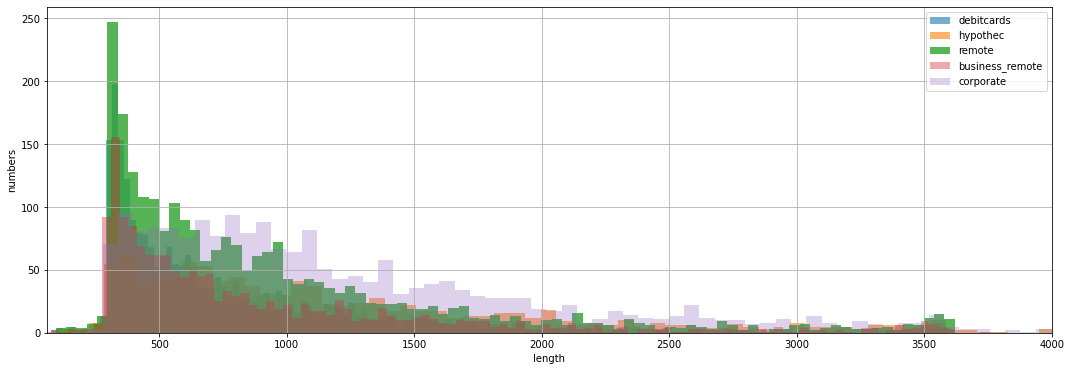

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df[df['Label'] == 'debitcards']['length'], alpha = 0.6, bins=bins, label='debitcards')
plt.hist(df[df['Label'] == 'hypothec']['length'], alpha = 0.6, bins=bins, label='hypothec')
plt.hist(df[df['Label'] == 'remote']['length'], alpha = 0.8, bins=bins, label='remote')
plt.hist(df[df['Label'] == 'business_remote']['length'], alpha = 0.4, bins=bins, label='business_remote')
plt.hist(df[df['Label'] == 'corporate']['length'], alpha = 0.3, bins=bins, label='corporate')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(60,4000)
plt.grid()
plt.show()

По данной гистограмме можем заметить, что бОльшая часть отзывов содержит менее 1500 символов. Длинные отзывы пишут, в основном, про ипотеку и удаленную работу.


Выведем распределение количества отзывов по классам:

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
LE = LabelEncoder()
df['le_label'] = LE.fit_transform(df['Label'])

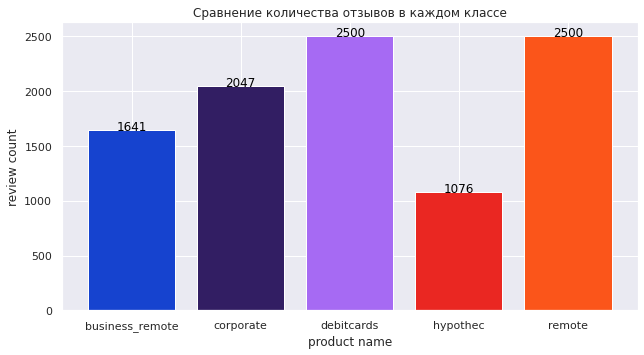

In [ ]:
sns.set()
counts = [len(df['le_label'][df['le_label'] == i]) for i in range(5)]
names = list(LE.classes_)
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(names, counts, color=['#1643CF','#321E63','#A66AF3','#EA2722','#FB551A'])
plt.title('Сравнение количества отзывов в каждом классе')
plt.ylabel('review count')
plt.xlabel('product name')
for i in range(len(names)):
    ax.text(names[i], counts[i], counts[i], color='black', ha="center")
plt.show()

Можно заметить, что меньше всего отзывов про ипотеку, больше всего про удаленную работу и дебетовые карты.

Одинаковое количество отзывов про удаленную работу и дебетовые карты вызвано тем, что при сборе датасета было ограничено количество загружаемых страниц с отзывами. Таким образом, сбор датасета не занимает слишком много времени и мы имеем приемлемый баланс классов.

In [ ]:
df.drop(['length', 'le_label', 'Mark', 'Checked'], inplace=True, axis=1)

# Построение моделей ML

## Вспомогательные функции

In [ ]:
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

def get_f1(true_labels, predicted_labels):
    return np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 6)
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):  
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features) 
    return predictions, classifier

    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)

## Модели ML

In [ ]:
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.metrics  import f1_score, accuracy_score
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import time

In [ ]:
lr = LogisticRegression(max_iter=1000, C=1)
sgd = SGDClassifier()
rf = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=7)
dt = DecisionTreeClassifier() 

In [ ]:
mlp = MLPClassifier(random_state = 1)

## Logistic Regression

Остановлюсь на рассмотрении на модели Логистической регрессии, ниже также приведеные прочие рассмотренные модели с более низкими метриками качества.


Стоит отметить, что, разумеется, все рассмотренные в этой части модели достаточно простые. Однако они показывают неплохие метрики, и в дальнейшем будут сравнены с более сложными нейронными сетями

In [ ]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.model_selection import cross_validate
from scipy import interp
from sklearn.metrics import roc_curve, auc 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
LE = LabelEncoder()
ml_df = pd.DataFrame()
ml_df['Label'] = LE.fit_transform(df['Label'])

In [ ]:
X = df['Text']
y = ml_df['Label']
tv = TfidfVectorizer(min_df=0.0, max_df=1.0, sublinear_tf=True)
X = tv.fit_transform(X)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=54)

In [ ]:
%%time
lr_tfidf_predictions, clf_lgr2 = train_predict_model(classifier=lr, 
                                               train_features=X_train2, train_labels=y_train2,
                                               test_features=X_test2, test_labels=y_test2)
display_model_performance_metrics(true_labels=y_test2, predicted_labels=lr_tfidf_predictions,
                                      classes=[0,1,2,3,4])

Model Performance metrics:
------------------------------
Accuracy: 0.6205
Precision: 0.6322
Recall: 0.6205
F1 Score: 0.6237

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       493
           1       0.69      0.73      0.71       623
           2       0.57      0.57      0.57       758
           3       0.98      0.79      0.88       316
           4       0.50      0.57      0.53       740

    accuracy                           0.62      2930
   macro avg       0.67      0.64      0.65      2930
weighted avg       0.63      0.62      0.62      2930

CPU times: user 11.8 s, sys: 12.1 s, total: 23.9 s
Wall time: 12.3 s


Text(45.994375, 0.5, 'Actual Classes')

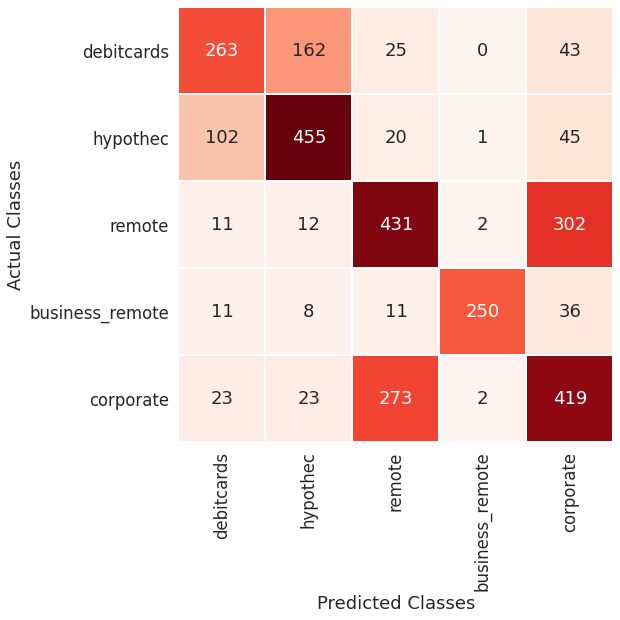

In [ ]:
cof=confusion_matrix(y_test2, lr_tfidf_predictions)
cof=pd.DataFrame(cof, index=[i for i in range(0,5)], columns=[i for i in range(0,5)])
sns.set(font_scale=1.5)
plt.figure(figsize=(8,8));

sns.heatmap(cof, cmap='Reds',linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=
                ['debitcards','hypothec','remote','business_remote', 'corporate'],
            yticklabels=['debitcards','hypothec','remote','business_remote', 'corporate']);
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")

Исходя из матрицы ошибок, можно заметить что модель неплохо отделяет отзывы по удаленной работе юр лиц от отзывов по остальным услугам банка. С немного менее высокой точностью модель предсказывает отзывы по дебетовым картам.

Наиболее затруднительно для алгоритма отделить отзывы по обслуживанию юр. лиц от их именно дистанционного обслуживания, что вполне логично, так как по сути второе является подчастью первого.

В целом Логистическая регрессия показывает неплохое качество предсказаний при затрате 12 секунд на обучение (на датасете с 9 тысячами строк).

Для проверки значимости результатов используем кросс валидацию и построим доверительный интервал для f1 score:

In [ ]:
lr_cv_f1 = cross_validate(lr, X, y, cv=10, scoring='f1_weighted')['test_score']

In [ ]:
f"Доверительный интервал f1 LR: {round(lr_cv_f1.mean(),2)} +/- {round(lr_cv_f1.std() * 2,2)}"

'Доверительный интервал f1 LR: 0.63 +/- 0.02'

Полученный результат может говорить об отсутствии переобучения на обучающей выборке.

## Grid Search Logistic Regression

In [ ]:
%%time
import itertools
import scipy
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def gridd(estimator, param_grid):
    clf = GridSearchCV(
                estimator=estimator, 
                param_grid=param_grid, 
                scoring=None,
                n_jobs=-1, 
                cv=10, 
                verbose=0,
                return_train_score=True)
    clf.fit(X=X_train2, y=y_train2)
    return clf   
logreg_params = {} 
logreg_params["C"] =  [0.01, 0.1, 10, 100]
logreg_params["fit_intercept"] =  [True, False]
logreg_params["warm_start"] = [True,False]
logreg_params["random_state"] = [1]
logregression_grid = gridd(LogisticRegression(), logreg_params)

CPU times: user 8.55 s, sys: 6 s, total: 14.5 s
Wall time: 6min 33s


In [ ]:
acc = accuracy_score(y_true=y_test2, y_pred=logregression_grid.predict(X_test2))
print("Grid search results")
print("Best training accuracy:\t", logregression_grid.best_score_)
print("Test accuracy:\t", acc)

Grid search results
Best training accuracy:	 0.6112093618624403
Test accuracy:	 0.6027303754266211


In [ ]:
display_model_performance_metrics(true_labels=y_test2, predicted_labels=logregression_grid.predict(X_test2),
                                      classes=[0,1,2,3,4])

Model Performance metrics:
------------------------------
Accuracy: 0.6027
Precision: 0.611
Recall: 0.6027
F1 Score: 0.6058

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       493
           1       0.69      0.70      0.70       623
           2       0.53      0.50      0.52       758
           3       0.97      0.84      0.90       316
           4       0.47      0.53      0.50       740

    accuracy                           0.60      2930
   macro avg       0.66      0.63      0.64      2930
weighted avg       0.61      0.60      0.61      2930



Исходя из метрик, лучше использовать стандартные гиперпараметры для Логистической Регрессии

## Прочие модели ML

In [ ]:
knn_cv_f1 = cross_validate(knn, X, y, cv=10, scoring='f1_weighted')['test_score']
f"Дов. интервал f1 KNN: {round(knn_cv_f1.mean(),2)} +/- {round(knn_cv_f1.std() * 2,2)}"

'Дов. интервал f1 KNN: 0.57 +/- 0.03'

In [ ]:
dt_cv_f1 = cross_validate(dt, X, y, cv=10, scoring='f1_weighted')['test_score']
f"Дов. интервал f1 DT: {round(dt_cv_f1.mean(),2)} +/- {round(dt_cv_f1.std() * 2,2)}"

'Дов. интервал f1 DT: 0.47 +/- 0.02'

In [ ]:
sgd_cv_f1 = cross_validate(sgd, X, y, cv=10, scoring='f1_weighted')['test_score']
f"Дов. интервал f1 SGD: {round(sgd_cv_f1.mean(),2)} +/- {round(sgd_cv_f1.std() * 2,2)}"

'Дов. интервал f1 SGD: 0.62 +/- 0.02'

# Модели NN

## MLP

In [ ]:
%%time
mlp_predictions, clf_mlp = train_predict_model(classifier=mlp, 
                                               train_features=X_train2, train_labels=y_train2,
                                              test_features=X_test2, test_labels=y_test2)

CPU times: user 9min 38s, sys: 5min 58s, total: 15min 36s
Wall time: 8min 48s


In [ ]:
display_model_performance_metrics(true_labels=y_test2, predicted_labels=mlp_predictions,
                                      classes=[0,1,2,3,4])

Model Performance metrics:
------------------------------
Accuracy: 0.5918
Precision: 0.6013
Recall: 0.5918
F1 Score: 0.5956

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.61      0.55      0.58       493
           1       0.70      0.67      0.68       623
           2       0.51      0.55      0.53       758
           3       0.95      0.84      0.89       316
           4       0.46      0.49      0.47       740

    accuracy                           0.59      2930
   macro avg       0.65      0.62      0.63      2930
weighted avg       0.60      0.59      0.60      2930



## Train-Test split & One_Hot

In [ ]:
one_hot = pd.get_dummies(df["Label"])
df.drop(['Label'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,Text,business_remote,corporate,debitcards,hypothec,remote
0,добрый день! много раз пополнял до этого карту...,0,0,0,0,1
1,хотел бы оставить отзыв о самом удобном банке....,0,1,0,0,0
2,прошу обратить внимание на нашу проблему.у нас...,0,1,0,0,0
3,"пользуюсь банком как ип, получаю платежи от ин...",1,0,0,0,0
4,являюсь клиентом тинькофф банка с ноября 2019 ...,0,0,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["Text"].values, 
                                                    df.drop(["Text"], axis=1).values, test_size=0.2, random_state=1)

In [ ]:
vocabulary_size = 100000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=50)

In [ ]:
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=50)

## LSTM

In [ ]:
model = Sequential()
model.add(Embedding(100000, 100, input_length=50))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(5, activation='softmax')) # 5 - number of classes

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=12,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/12
7/7 [==============================] - 25s 811ms/step - loss: 1.5985 - accuracy: 0.2357 - val_loss: 1.5759 - val_accuracy: 0.2417
Epoch 2/12
7/7 [==============================] - 5s 660ms/step - loss: 1.5617 - accuracy: 0.2589 - val_loss: 1.5621 - val_accuracy: 0.2468
Epoch 3/12
7/7 [==============================] - 5s 649ms/step - loss: 1.5429 - accuracy: 0.2586 - val_loss: 1.5428 - val_accuracy: 0.2481
Epoch 4/12
7/7 [==============================] - 5s 664ms/step - loss: 1.4877 - accuracy: 0.2881 - val_loss: 1.4807 - val_accuracy: 0.2570
Epoch 5/12
7/7 [==============================] - 5s 665ms/step - loss: 1.3368 - accuracy: 0.3436 - val_loss: 1.3911 - val_accuracy: 0.3772
Epoch 6/12
7/7 [==============================] - 5s 660ms/step - loss: 1.1680 - accuracy: 0.4915 - val_loss: 1.3930 - val_accuracy: 0.3760
Epoch 7/12
7/7 [==============================] - 5s 658ms/step - loss: 1.0047 - accuracy: 0.5250 - val_loss: 1.3962 - val_accuracy: 0.3721
Epoch 8/12
7/7 [===

In [ ]:
score = model.evaluate(X_test, y_test,
                       batch_size=256, verbose=1)
f'Test accuracy:{score[1]}'

8/8 [==============================] - 0s 43ms/step - loss: 2.0963 - accuracy: 0.4055


'Test accuracy:0.4055299460887909'

In [ ]:
preds = model.predict(X_test)

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))

              precision    recall  f1-score   support

           0       0.42      0.32      0.37       355
           1       0.40      0.52      0.45       374
           2       0.48      0.33      0.39       481
           3       0.57      0.45      0.50       222
           4       0.33      0.43      0.37       521

    accuracy                           0.41      1953
   macro avg       0.44      0.41      0.42      1953
weighted avg       0.42      0.41      0.41      1953



## Custom Embedding

[Источник эмбеддинга](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/)

Для удобства я загрузил его на свой dropbox

In [ ]:
!wget https://dl.dropbox.com/s/jwj2yctlee55ss9/ruwiki_20180420_100d.txt

--2021-06-15 09:01:03--  https://dl.dropbox.com/s/jwj2yctlee55ss9/ruwiki_20180420_100d.txt
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/jwj2yctlee55ss9/ruwiki_20180420_100d.txt [following]
--2021-06-15 09:01:04--  https://dl.dropboxusercontent.com/s/jwj2yctlee55ss9/ruwiki_20180420_100d.txt
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2023075311 (1.9G) [text/plain]
Saving to: ‘ruwiki_20180420_100d.txt’

ruwiki_20180420_100 100%[===================>]   1.88G  44.8MB/s    in 46s     

2021-06-15 09:01:50 (42.2 MB/s) - ‘ruwiki_20180420_100d.txt’ saved [2023075311/2

Новая Токенизация

In [ ]:
from keras.preprocessing import sequence, text

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["Text"].values, df.drop(['Text'],axis=1).values, test_size=0.2, random_state=42)

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

Загрузка векторов в словарь

In [ ]:
embeddings_index = {}
f = open('ruwiki_20180420_100d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

f'Found {len(embeddings_index)} word vectors'

2602508it [01:35, 27141.52it/s]


'Found 2602508 word vectors'

Создаем embedding matrix для слов из нашего датасета

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 68044/68044 [00:00<00:00, 424575.04it/s]


In [ ]:
model_c = Sequential()
model_c.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model_c.add(Dropout(0.2))
model_c.add(MaxPooling1D(pool_size=2))
model_c.add(LSTM(100))
model_c.add(Dense(5, activation='softmax')) # 5 - number of classes

In [ ]:
model_c.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_c.fit(xtrain_pad, y_train,
                    batch_size=1024,
                    epochs=20,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
7/7 [==============================] - 77s 11s/step - loss: 1.5916 - accuracy: 0.2270 - val_loss: 1.5601 - val_accuracy: 0.2647
Epoch 2/20
7/7 [==============================] - 77s 11s/step - loss: 1.5668 - accuracy: 0.2647 - val_loss: 1.5587 - val_accuracy: 0.2749
Epoch 3/20
7/7 [==============================] - 74s 11s/step - loss: 1.5500 - accuracy: 0.2874 - val_loss: 1.5407 - val_accuracy: 0.2852
Epoch 4/20
7/7 [==============================] - 73s 10s/step - loss: 1.5245 - accuracy: 0.3084 - val_loss: 1.5378 - val_accuracy: 0.2980
Epoch 5/20
7/7 [==============================] - 73s 10s/step - loss: 1.5024 - accuracy: 0.3167 - val_loss: 1.4961 - val_accuracy: 0.3338
Epoch 6/20
7/7 [==============================] - 72s 10s/step - loss: 1.4603 - accuracy: 0.3600 - val_loss: 1.4339 - val_accuracy: 0.3517
Epoch 7/20
7/7 [==============================] - 72s 10s/step - loss: 1.4568 - accuracy: 0.3641 - val_loss: 1.4036 - val_accuracy: 0.3926
Epoch 8/20
7/7 [===========

In [ ]:
preds = model_c.predict(xvalid_pad)

In [ ]:
score = model_c.evaluate(xvalid_pad, y_test,
                       batch_size=256, verbose=1)
f'Test accuracy:{score[1]}'

8/8 [==============================] - 9s 1s/step - loss: 1.3449 - accuracy: 0.4419


'Test accuracy:0.44188427925109863'

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))

              precision    recall  f1-score   support

           0       0.38      0.57      0.45       325
           1       0.38      0.80      0.51       407
           2       0.61      0.47      0.53       530
           3       0.81      0.26      0.39       203
           4       0.41      0.11      0.17       488

    accuracy                           0.44      1953
   macro avg       0.52      0.44      0.41      1953
weighted avg       0.49      0.44      0.41      1953



Дообучим старую модель с новой токенизацией признака-текста

In [ ]:
model.fit(xtrain_pad, y_train,
                    batch_size=1024,
                    epochs=20,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
7/7 [==============================] - 175s 18s/step - loss: 2.4433 - accuracy: 0.2107 - val_loss: 1.6775 - val_accuracy: 0.2263
Epoch 2/20
7/7 [==============================] - 130s 19s/step - loss: 1.5032 - accuracy: 0.3218 - val_loss: 1.5187 - val_accuracy: 0.3005
Epoch 3/20
7/7 [==============================] - 130s 19s/step - loss: 1.3325 - accuracy: 0.4092 - val_loss: 1.4041 - val_accuracy: 0.3619
Epoch 4/20
7/7 [==============================] - 133s 19s/step - loss: 1.2060 - accuracy: 0.4772 - val_loss: 1.3648 - val_accuracy: 0.3951
Epoch 5/20
7/7 [==============================] - 128s 18s/step - loss: 1.0844 - accuracy: 0.5521 - val_loss: 1.3330 - val_accuracy: 0.4054
Epoch 6/20
7/7 [==============================] - 128s 18s/step - loss: 0.9578 - accuracy: 0.5992 - val_loss: 1.3067 - val_accuracy: 0.4412
Epoch 7/20
7/7 [==============================] - 128s 18s/step - loss: 0.8191 - accuracy: 0.6765 - val_loss: 1.2999 - val_accuracy: 0.4271
Epoch 8/20
7/7 [====

По метрикам на трейне и тесте можно понять, что модель переобучилась

In [ ]:
score = model.evaluate(xvalid_pad, y_test,
                       batch_size=256, verbose=1)
f'Test accuracy:{score[1]}'

8/8 [==============================] - 11s 1s/step - loss: 2.2427 - accuracy: 0.4286


'Test accuracy:0.4285714328289032'

In [ ]:
preds = model.predict(xvalid_pad)

Метрики немного снизились

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))

              precision    recall  f1-score   support

           0       0.35      0.45      0.39       325
           1       0.45      0.39      0.42       407
           2       0.50      0.41      0.45       530
           3       0.56      0.61      0.58       203
           4       0.37      0.39      0.38       488

    accuracy                           0.43      1953
   macro avg       0.44      0.45      0.44      1953
weighted avg       0.44      0.43      0.43      1953



# Выводы

## Модели

Лучшие результаты показала относительно простая модель логистической регрессии, модель LSTM а также LSTM с предобученными эмбеддингами показали результаты ниже по любым метрикам.


Тем не менее, даже лучшая модель LOG REG показывает метрику f1-score ниже 0.7, что является далеко не лучшим показателем. **Вполне вероятно, что на практике будет целесообразно объединить некоторые классы, которые модель плохо различает (видно в матрице ошибок)**

## Область Применения

Модель может применяться для классификации обращений в техническую поддержку с какими-либо вопросами и сложностями клиентов. Модель может предсказать вид услуг по тексту отзыва и сразу передать обращение нужному сотруднику, повысив КПД техподдержки.

Также, по имеющимся данным можно построить модель предсказания оценки, которую поставит пользователь по тексту его отзыва. Так можно отделять негативные упоминания банка в социальных сетях и оперативно реагировать на них. В автоматическом режиме, в виде 'уточните вашу проблему в личном сообщении'. Даже такое простое применение алгоритма может повысить лояльность всех тех, кто увидит сообщение в соц. сети.